# Random Forest with Random Oversampling and SMOTE
This notebook applies class balancing using Random Oversampling and SMOTE and evaluates a Random Forest classifier.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_1454/1171060083.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load and split dataset
df = pd.read_csv("KNN_Imputed_Water_Potability_Dataset__Full_View_.csv")
X = df.drop('Potability', axis=1)
y = df['Potability']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [3]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Random Oversampling
class_0 = X_train_scaled[y_train == 0]
class_1 = X_train_scaled[y_train == 1]
class_1_upsampled = class_1[np.random.choice(len(class_1), len(class_0), replace=True)]
X_over = np.vstack([class_0, class_1_upsampled])
y_over = pd.Series([0]*len(class_0) + [1]*len(class_1_upsampled))

In [5]:
# SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)

In [6]:
# Evaluation function
def evaluate_rf(X_res, y_res, label):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["Not Potable", "Potable"]).plot(cmap='Blues')
    plt.title(f"{label} - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{label} - ROC Curve")
    plt.legend()
    plt.show()

    # Metrics
    report = classification_report(y_test, y_pred, digits=4)
    print(f"{label} - Classification Report:\n", report)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")

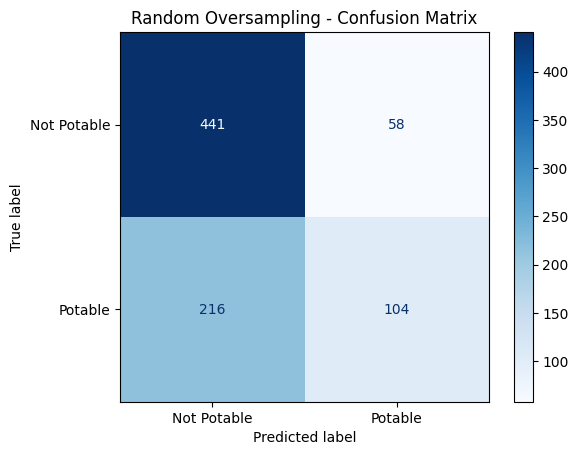

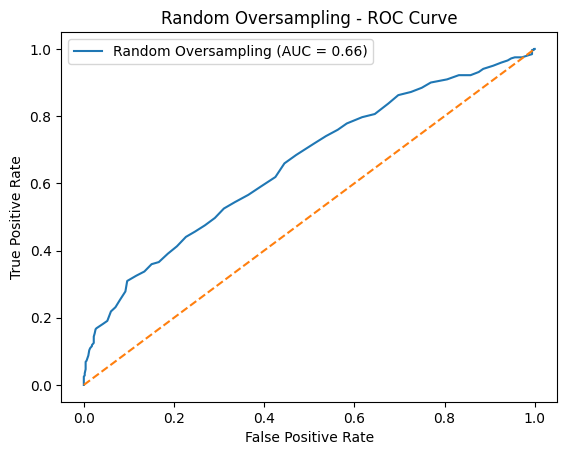

Random Oversampling - Classification Report:
               precision    recall  f1-score   support

         0.0     0.6712    0.8838    0.7630       499
         1.0     0.6420    0.3250    0.4315       320

    accuracy                         0.6654       819
   macro avg     0.6566    0.6044    0.5973       819
weighted avg     0.6598    0.6654    0.6335       819

Accuracy: 0.6654



In [7]:
# Evaluate Random Forest with Random Oversampling
evaluate_rf(X_over, y_over, "Random Oversampling")

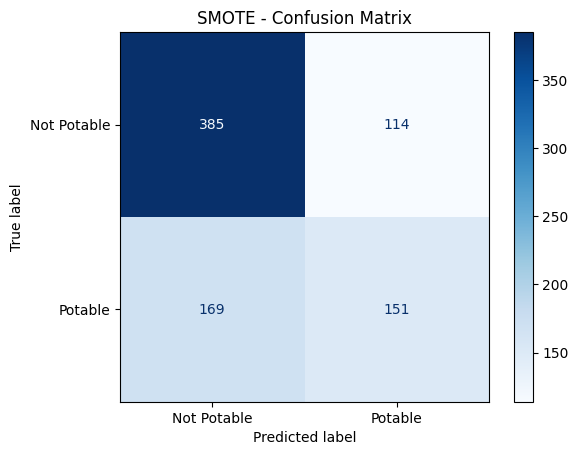

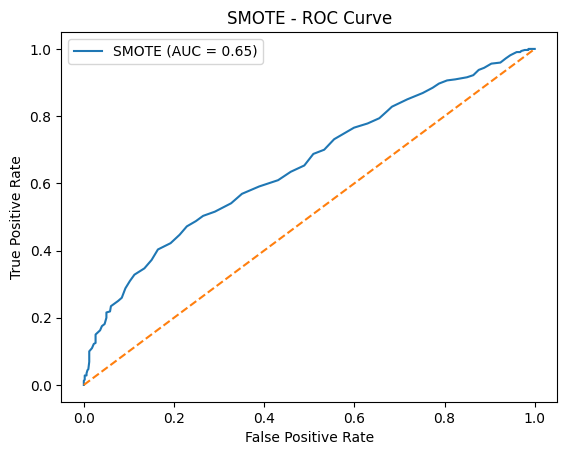

SMOTE - Classification Report:
               precision    recall  f1-score   support

         0.0     0.6949    0.7715    0.7312       499
         1.0     0.5698    0.4719    0.5162       320

    accuracy                         0.6545       819
   macro avg     0.6324    0.6217    0.6237       819
weighted avg     0.6461    0.6545    0.6472       819

Accuracy: 0.6545



In [8]:
# Evaluate Random Forest with SMOTE
evaluate_rf(X_smote, y_smote, "SMOTE")

/home/fs239188/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:49:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


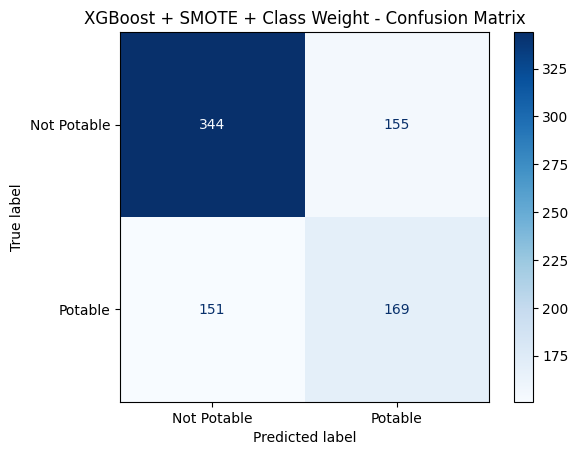

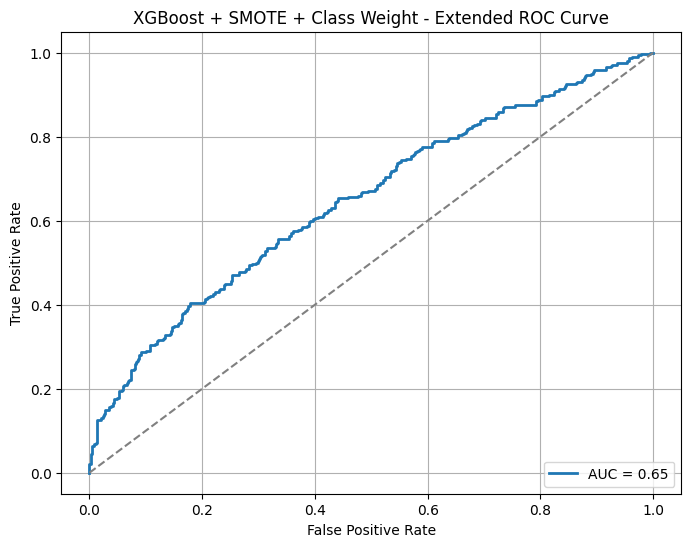

Classification Report:
              precision    recall  f1-score   support

         0.0     0.6949    0.6894    0.6922       499
         1.0     0.5216    0.5281    0.5248       320

    accuracy                         0.6264       819
   macro avg     0.6083    0.6088    0.6085       819
weighted avg     0.6272    0.6264    0.6268       819



In [2]:
#xgboost with smote and balanced
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("KNN_Imputed_Water_Potability_Dataset__Full_View_.csv")
X = df.drop('Potability', axis=1)
y = df['Potability']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)

# Compute scale_pos_weight for XGBoost: ratio of negative to positive class
scale_pos_weight = len(y_smote[y_smote == 0]) / len(y_smote[y_smote == 1])

# Train XGBoost with SMOTE'd data and class weight
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                    random_state=42, scale_pos_weight=scale_pos_weight)
xgb.fit(X_smote, y_smote)

# Predict and evaluate
y_pred = xgb.predict(X_test_scaled)
y_prob = xgb.predict_proba(X_test_scaled)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Not Potable", "Potable"]).plot(cmap='Blues')
plt.title("XGBoost + SMOTE + Class Weight - Confusion Matrix")
plt.show()

# ROC Curve with extension to (0,0) and (1,1)
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Extend for visual flatline
fpr_extended = np.concatenate([[0], fpr, [1]])
tpr_extended = np.concatenate([[0], tpr, [1]])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_extended, tpr_extended, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost + SMOTE + Class Weight - Extended ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


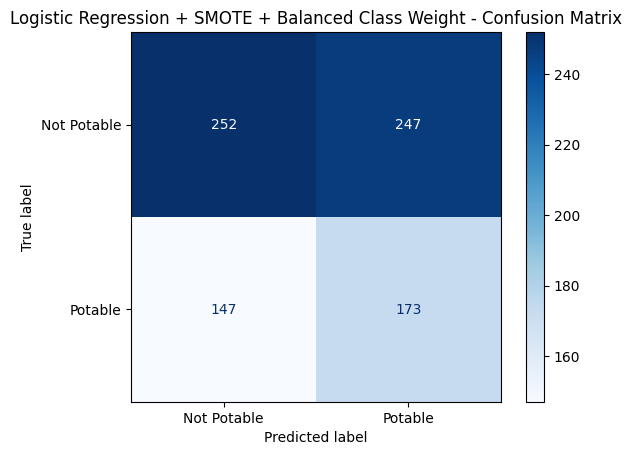

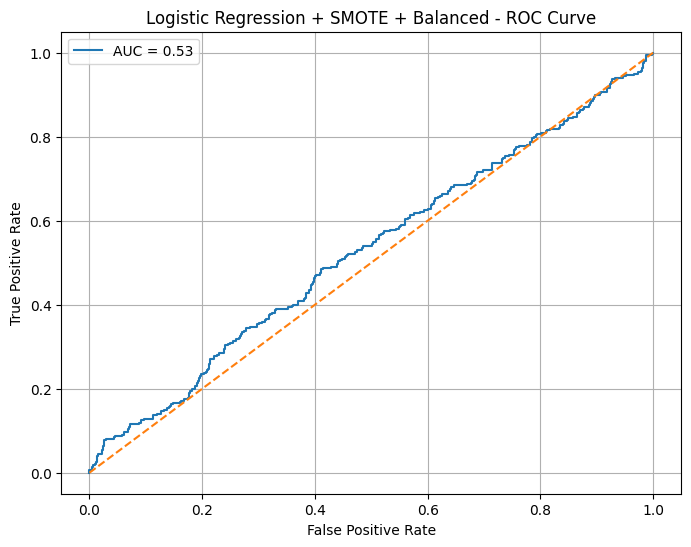

Classification Report:
              precision    recall  f1-score   support

         0.0     0.6316    0.5050    0.5612       499
         1.0     0.4119    0.5406    0.4676       320

    accuracy                         0.5189       819
   macro avg     0.5217    0.5228    0.5144       819
weighted avg     0.5457    0.5189    0.5246       819



In [3]:
#logistic r
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("KNN_Imputed_Water_Potability_Dataset__Full_View_.csv")
X = df.drop('Potability', axis=1)
y = df['Potability']

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)

# Train Logistic Regression with class_weight='balanced'
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_smote, y_smote)

# Predict
y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Not Potable", "Potable"]).plot(cmap="Blues")
plt.title("Logistic Regression + SMOTE + Balanced Class Weight - Confusion Matrix")
plt.show()

# ROC Curve (extended)
fpr, tpr, _ = roc_curve(y_test, y_prob)
fpr_ext = np.concatenate([[0], fpr, [1]])
tpr_ext = np.concatenate([[0], tpr, [1]])

plt.figure(figsize=(8, 6))
plt.plot(fpr_ext, tpr_ext, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("Logistic Regression + SMOTE + Balanced - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))



🔍 Best threshold based on F1-score: 0.30
Threshold    0.300000
Precision    0.421203
Recall       0.918750
F1           0.577603
Name: 4, dtype: float64


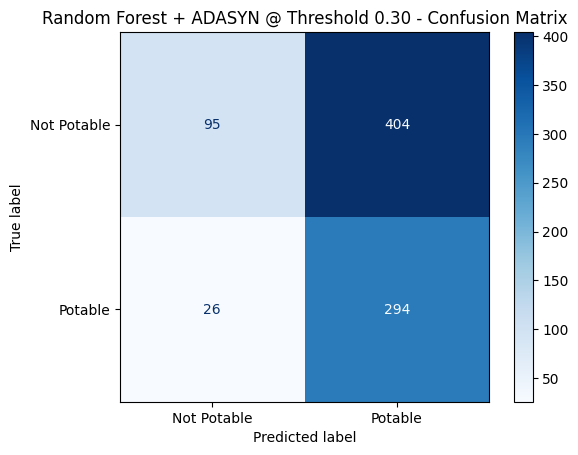

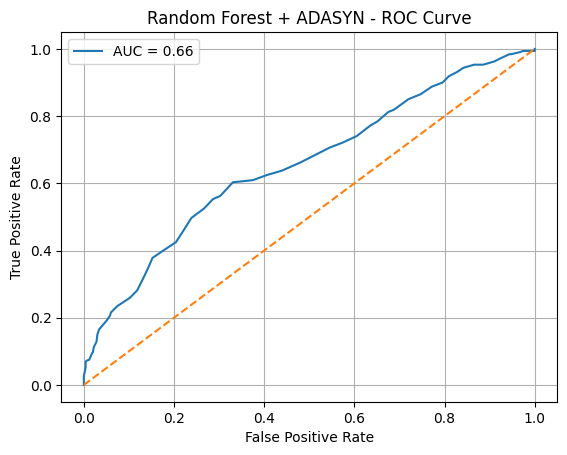

Classification Report (using threshold = 0.30):
              precision    recall  f1-score   support

         0.0     0.7851    0.1904    0.3065       499
         1.0     0.4212    0.9187    0.5776       320

    accuracy                         0.4750       819
   macro avg     0.6032    0.5546    0.4420       819
weighted avg     0.6429    0.4750    0.4124       819



In [4]:
#rf+ adasyn+threshold tuning

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_fscore_support, ConfusionMatrixDisplay
)
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("KNN_Imputed_Water_Potability_Dataset__Full_View_.csv")
X = df.drop('Potability', axis=1)
y = df['Potability']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train_scaled, y_train)

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_adasyn, y_adasyn)

# Predict probabilities
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

# Threshold tuning
thresholds = np.arange(0.1, 0.91, 0.05)
metrics = []

for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary', zero_division=0)
    metrics.append((t, precision, recall, f1))

# Convert to DataFrame for viewing
metrics_df = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1"])
best_idx = metrics_df["F1"].idxmax()
best_threshold = metrics_df.loc[best_idx, "Threshold"]
print(f"\n🔍 Best threshold based on F1-score: {best_threshold:.2f}")
print(metrics_df.loc[best_idx])

# Final predictions and evaluation at best threshold
y_pred_final = (y_prob >= best_threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
ConfusionMatrixDisplay(cm, display_labels=["Not Potable", "Potable"]).plot(cmap='Blues')
plt.title(f"Random Forest + ADASYN @ Threshold {best_threshold:.2f} - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest + ADASYN - ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Classification Report
print("Classification Report (using threshold = {:.2f}):".format(best_threshold))
print(classification_report(y_test, y_pred_final, digits=4))
